In [1]:
from segmenter_api.utils.file import get_project_dir

%cd {get_project_dir()}
print(get_project_dir())

/home/yoshino_teppei/ghq/github.com/Tyaba/segmenter-api
/home/yoshino_teppei/ghq/github.com/Tyaba/segmenter-api


In [26]:
from pathlib import Path

import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor

from segmenter_api.utils.image import draw_bboxes

In [18]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
model_path = Path("models/microsoft/Florence-2-base")
if not model_path.exists():
    model_path = "microsoft/Florence-2-base"
model = AutoModelForCausalLM.from_pretrained(
    model_path, torch_dtype=torch_dtype, trust_remote_code=True
).to(device)
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [19]:
task_prompt = "<OPEN_VOCABULARY_DETECTION>"
text_input = "cosmetics"
image_path = Path("data/multiple_products.png")
image = Image.open(image_path).convert("RGB")
prompt = f"{task_prompt}{text_input}"

In [20]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to(
    device, torch_dtype
)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
)

generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=False)

In [21]:
parsed_answers = [
    processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height),
    )
    for generated_text in generated_texts
]

print(parsed_answers)


[{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[316.20001220703125, 273.4940185546875, 612.6000366210938, 561.7460327148438], [587.4000244140625, 66.88200378417969, 749.4000244140625, 564.2579956054688], [695.4000244140625, 276.6340026855469, 905.4000244140625, 578.7020263671875]], 'bboxes_labels': ['cosmetics', 'cosmetics', 'cosmetics'], 'polygons': [], 'polygons_labels': []}}]


In [22]:
print(len(parsed_answers))
print(parsed_answers[0])

1
{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[316.20001220703125, 273.4940185546875, 612.6000366210938, 561.7460327148438], [587.4000244140625, 66.88200378417969, 749.4000244140625, 564.2579956054688], [695.4000244140625, 276.6340026855469, 905.4000244140625, 578.7020263671875]], 'bboxes_labels': ['cosmetics', 'cosmetics', 'cosmetics'], 'polygons': [], 'polygons_labels': []}}


In [23]:
parsed_answers[0]["<OPEN_VOCABULARY_DETECTION>"]

{'bboxes': [[316.20001220703125,
   273.4940185546875,
   612.6000366210938,
   561.7460327148438],
  [587.4000244140625, 66.88200378417969, 749.4000244140625, 564.2579956054688],
  [695.4000244140625,
   276.6340026855469,
   905.4000244140625,
   578.7020263671875]],
 'bboxes_labels': ['cosmetics', 'cosmetics', 'cosmetics'],
 'polygons': [],
 'polygons_labels': []}

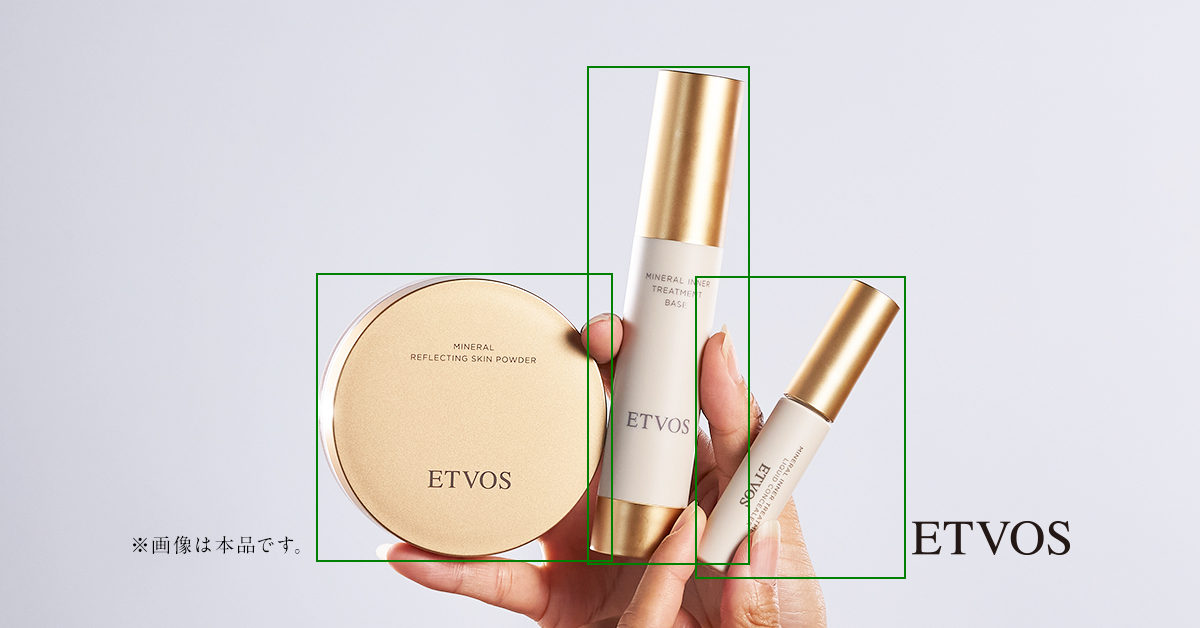

In [27]:
draw_bboxes(
    image=image,
    bboxes=parsed_answers[0]["<OPEN_VOCABULARY_DETECTION>"]["bboxes"],
    color="green",
)
